# Mask R-CNN

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import glob
import random
import math
import numpy as np
import skimage.io
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt

from MaskRCNN.config import Config
import MaskRCNN.utils as utils
import MaskRCNN.model as modellib
import MaskRCNN.visualize as visualize
from MaskRCNN.model import log

C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("Download the COCO trained weights")
    # utils.download_trained_weights(COCO_MODEL_PATH)
    

In [4]:
train_path = os.path.join(ROOT_DIR, 'input/stage1_train')
val_path = os.path.join(ROOT_DIR,'input/stage1_val')
test_path = os.path.join(ROOT_DIR, 'input/stage1_test')   #path to test data file/folder

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [5]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
#     IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
#     TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
#     STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
#     VALIDATION_STEPS = 5
    
#     USE_MINI_MASK = False
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING    

In [6]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING    

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [11]:
def display_masks(image, mask, class_names):
    """Display the given image and the masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    
#     to_display.append(mask)
    
    # Pull masks of instances belonging to the same class.
    m = mask
    m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
    to_display.append(m)
    titles.append("H x W={}x{} - {}".format(image.shape[0], image.shape[1], class_names[0]))
    visualize.display_images(to_display, titles=titles, cols=2, cmap="Blues_r")

In [43]:
class NucleiDataset(utils.Dataset):
    """Loads the nuclei dataset.
    """
    
    def load_nuclei(self, path):
        '''
        Loads images from path/{id}/images/{id}.png
        '''
        self.add_class("nuclei", 1, "nuclei")
        self.path = path
        
        img_info = [(id, '{0}/{1}/images/{1}.png'.format(path, id)) for id in os.listdir(path)]
        for id, path in img_info:
            data = plt.imread(path)[:, :, 0]
            height, width = data.shape
            
            self.add_image('nuclei', id, path, width=width, height=height)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclei":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, 0:3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def load_mask(self, image_id, width=256, height=256):
        '''
        Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array. 
        Generate instance masks for shapes of the given image ID.
        '''
        info = self.image_info[image_id]
        
        img_paths = glob.glob('{0}/{1}/masks/*.png'.format(self.path, info['id']))
        num_labels = len(img_paths)
        

#         masks = skimage.io.imread_collection(img_paths).concatenate()  #masks.shape = (num_masks, img_height, img_width)
#         mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
#         plt.imshow(mask)
#         mask = skimage.transform.resize(mask, output_shape=mask.shape+(num_labels,), mode='constant', preserve_range=True)
#         Y_data = np.array(mask, dtype=np.bool)
        width = info['width']
        height = info['height']
        mask = np.zeros([height,
                         width,
                         num_labels],
                        dtype=np.bool)
        num_labels = 0
        for i, mask_file in enumerate(img_paths):
#             subpath = os.path.join(root_path, 'masks', mask_file)
            data = plt.imread(mask_file)[:, :]
        
            if np.sum(data) != 0:
                data = (data != 0)
                mask[:, :, num_labels] = data
                num_labels += 1
        
        class_ids = np.array([1] * num_labels)
        class_ids = class_ids.astype(np.int32)
        
        self.image_info[image_id]['mask_shape'] = mask.shape
        
        return mask, class_ids

In [44]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(train_path)
dataset_train.prepare()

(256, 320, 3)
3
(256, 320, 75)


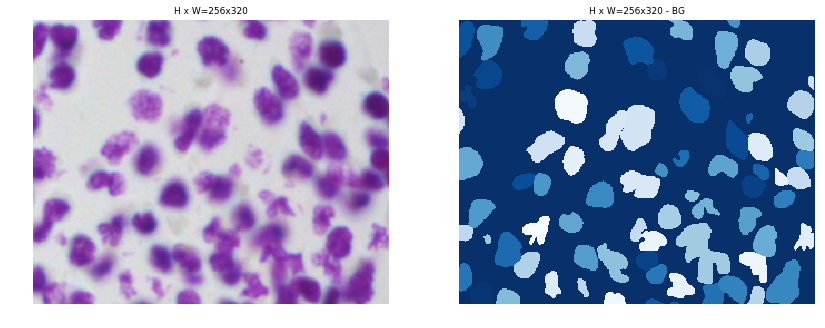

(256, 256, 3)
3
(256, 256, 54)


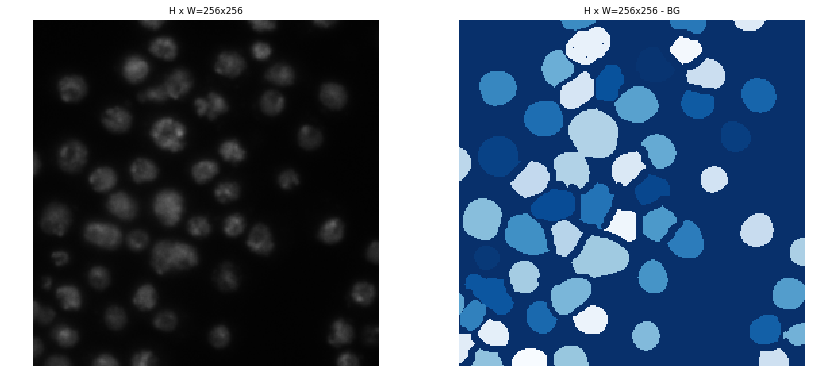

(256, 320, 3)
3
(256, 320, 8)


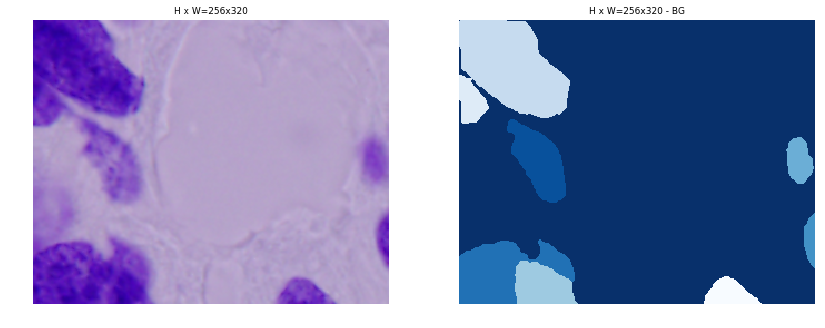

(256, 256, 3)
3
(256, 256, 53)


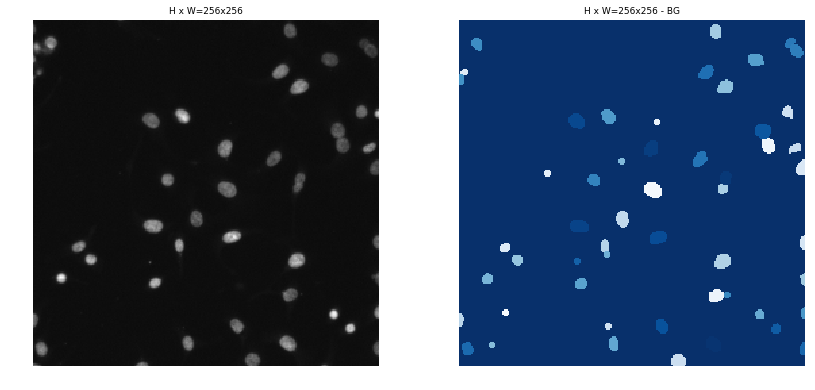

In [45]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)[:, :, 0:3]
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    print(image.ndim)
    print(mask.shape)
    display_masks(image, mask, dataset_train.class_names)

In [46]:
# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(val_path)
dataset_val.prepare()

In [47]:
print(dataset_train.image_ids[2])
print(dataset_train.image_info[0]['id'])

2
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552


In [48]:
print(dataset_val.image_ids[2])
print(dataset_val.image_info[0]['id'])

2
05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13


## Create Model

In [40]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [41]:
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Training

In [49]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: E:\workspace\dl\data-science-bowl-2018\logs\nuclei20180309T1835\mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[8,256,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/SGD/gradients/rpn_model/rpn_bbox_pred/convolution_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@rpn_model/rpn_bbox_pred/convolution"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/gradients/rpn_model/rpn_bbox_pred/convolution_grad/ShapeN, rpn_bbox_pred/kernel/read, training/SGD/gradients/rpn_model/lambda_3/Reshape_grad/Reshape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_19/_5181 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17998_Mean_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/SGD/gradients/rpn_model/rpn_bbox_pred/convolution_grad/Conv2DBackpropInput', defined at:
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-83fb3ae74319>", line 8, in <module>
    layers='heads')
  File "E:\workspace\dl\data-science-bowl-2018\MaskRCNN\model.py", line 2238, in train
    use_multiprocessing=True,
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2088, in fit_generator
    self._make_train_function()
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py", line 168, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 2512, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 611, in gradients
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 377, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 611, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 514, in _Conv2DGrad
    data_format=data_format),
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 917, in conv2d_backprop_input
    dilations=dilations, name=name)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'rpn_model/rpn_bbox_pred/convolution', defined at:
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 16 identical lines from previous traceback]
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-7928c4edfc77>", line 3, in <module>
    model_dir=MODEL_DIR)
  File "E:\workspace\dl\data-science-bowl-2018\MaskRCNN\model.py", line 1763, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "E:\workspace\dl\data-science-bowl-2018\MaskRCNN\model.py", line 1858, in build
    layer_outputs.append(rpn([p]))
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 2081, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 2232, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\layers\convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 781, in convolution
    return op(input, filter)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 869, in __call__
    return self.conv_op(inp, filter)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 521, in __call__
    return self.call(inp, filter)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 205, in __call__
    name=self.name)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 717, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "C:\Users\aadim\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[8,256,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/SGD/gradients/rpn_model/rpn_bbox_pred/convolution_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@rpn_model/rpn_bbox_pred/convolution"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/gradients/rpn_model/rpn_bbox_pred/convolution_grad/ShapeN, rpn_bbox_pred/kernel/read, training/SGD/gradients/rpn_model/lambda_3/Reshape_grad/Reshape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_19/_5181 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17998_Mean_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

